# PyMunk Crash Simulation: Crumple Zones vs Rigid Impact
**Author:** Darren Chung

**Date:** May 18, 2025


## 1. Introduction

This notebook demonstrates a physics simulation using `pymunk` to evaluate how crumple zones reduce the force transmitted to a car’s cabin during a collision. Two models are compared:
1. A single rigid body hitting a wall
2. A vehicle made of spring-connected segments (a crumple zone) followed by a cabin

We simulate collisions at various speeds and analyze the peak impulse experienced by the cabin.


In [1]:
import pymunk
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def simulate_impact(v_init, use_crumple, k=1000, damping=50,
                    n_seg=5, seg=(20, 10), cabin_mass=5.0,
                    dt=1/2000, T=1.5):
    space = pymunk.Space()
    space.gravity = (0, 0)
    wall = pymunk.Segment(pymunk.Body(body_type=pymunk.Body.STATIC), (0, -100), (0, 100), 1)
    wall.elasticity = 0.1
    wall.friction = 0.5
    space.add(wall.body, wall)
    peak_wall_imp = 0.0
    def post_solve(arb, space, data):
        nonlocal peak_wall_imp
        if wall in arb.shapes:
            peak_wall_imp = max(peak_wall_imp, arb.total_impulse.length)
    space.add_default_collision_handler().post_solve = post_solve
    spring_to_cabin = None
    if not use_crumple:
        body = pymunk.Body(1, pymunk.moment_for_box(1, seg))
        body.position = (-80, 0)
        body.velocity = (v_init, 0)
        shape = pymunk.Poly.create_box(body, seg)
        shape.elasticity = 0.1
        shape.friction = 0.5
        space.add(body, shape)
        cabin = body
    else:
        bodies = []
        w, h = seg
        for i in range(n_seg):
            m = cabin_mass if i == n_seg - 1 else 1
            b = pymunk.Body(m, pymunk.moment_for_box(m, seg))
            b.position = (-80 - i * w, 0)
            b.velocity = (v_init, 0)
            shape = pymunk.Poly.create_box(b, seg)
            shape.elasticity = 0.1
            shape.friction = 0.5
            space.add(b, shape)
            bodies.append(b)
        for i in range(n_seg - 1):
            s = pymunk.DampedSpring(
                bodies[i], bodies[i + 1],
                (w / 2, 0), (-w / 2, 0),
                rest_length=w, stiffness=k, damping=damping
            )
            space.add(s)
            if i == n_seg - 2:
                spring_to_cabin = s
        cabin = bodies[-1]
    peak_cabin_impulse = 0.0
    for _ in range(int(T / dt)):
        space.step(dt)
        if use_crumple and spring_to_cabin:
            peak_cabin_impulse = max(peak_cabin_impulse, abs(spring_to_cabin.impulse / dt))
        elif not use_crumple:
            peak_cabin_impulse = peak_wall_imp / dt
    return peak_wall_imp, peak_cabin_impulse

## 2. Run Simulations and Collect Data

In [3]:
speeds = [50, 100, 150, 200, 250]
results = []
for v in speeds:
    bi_r, ci_r = simulate_impact(v, use_crumple=False)
    bi_c, ci_c = simulate_impact(v, use_crumple=True)
    results.extend([
        dict(Design="Rigid", Speed=v, Barrier=bi_r / 1000, Cabin=ci_r / 1000),
        dict(Design="Crumple", Speed=v, Barrier=bi_c / 1000, Cabin=ci_c / 1000),
    ])
df = pd.DataFrame(results)
df

,Design,Speed,Barrier,Cabin
0,Rigid,50,0.050562,101.123886
1,Crumple,50,0.208234,20.126193
2,Rigid,100,0.101124,202.247773
3,Crumple,100,0.416397,20.255687
4,Rigid,150,0.151686,303.371659
5,Crumple,150,0.624561,20.385718
6,Rigid,200,0.202248,404.495545
7,Crumple,200,0.832725,20.516611
8,Rigid,250,0.252810,505.619431
9,Crumple,250,1.035724,20.370247


## 3. Analyze Reduction in Cabin Impulse

In [4]:
reductions = []
for v in speeds:
    rigid = df[(df.Design == "Rigid") & (df.Speed == v)].iloc[0]
    crumple = df[(df.Design == "Crumple") & (df.Speed == v)].iloc[0]
    red = 100 * (rigid.Cabin - crumple.Cabin) / rigid.Cabin
    reductions.append(dict(Speed=v, Reduction=red))
df_reduction = pd.DataFrame(reductions)
df_reduction

,Speed,Reduction
0,50,80.097488
1,100,89.984717
2,150,93.280283
3,200,94.927852
4,250,95.971229


## 4. Plot Peak Impulse vs Speed

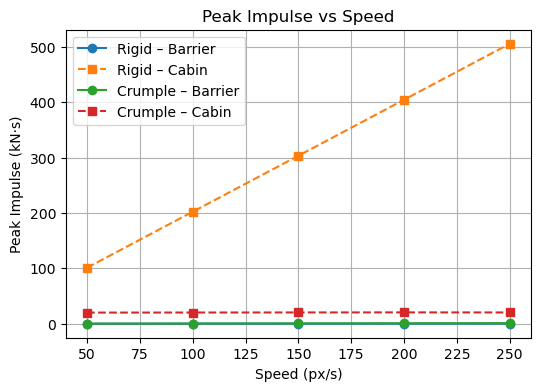

In [5]:
plt.figure(figsize=(6, 4))
for design in df['Design'].unique():
    g = df[df.Design == design]
    plt.plot(g.Speed, g.Barrier, 'o-', label=f'{design} – Barrier')
    plt.plot(g.Speed, g.Cabin, 's--', label=f'{design} – Cabin')
plt.title("Peak Impulse vs Speed")
plt.xlabel("Speed (px/s)")
plt.ylabel("Peak Impulse (kN·s)")
plt.grid(True)
plt.legend()
plt.savefig("Figure1.png",dpi=300)

## 5. Plot Reduction Bar Chart

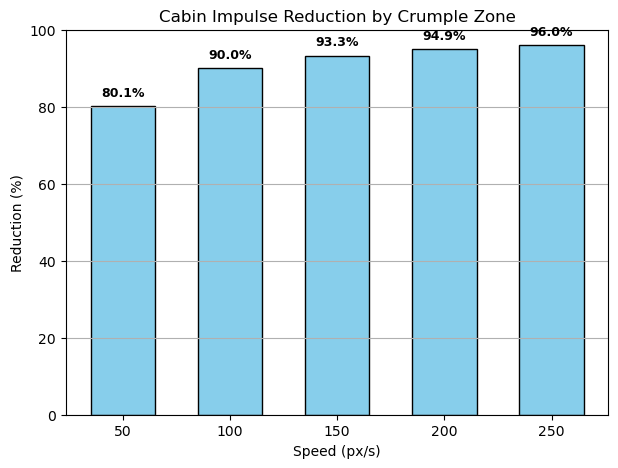

In [6]:
plt.figure(figsize=(7, 5))
bars = plt.bar(df_reduction.Speed, df_reduction.Reduction, width=30, color='skyblue', edgecolor='black')
plt.title("Cabin Impulse Reduction by Crumple Zone")
plt.xlabel("Speed (px/s)")
plt.ylabel("Reduction (%)")
plt.ylim(0, 100)
plt.grid(axis="y")
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9, fontweight='bold') 
plt.savefig("Figure2.png",dpi=300)


## 6. Summary

This simulation shows that crumple zones:
- Reduce cabin impulse significantly across all speeds
- Do not substantially increase wall impulse
- Allow for safer deceleration during impacts

The `pymunk` library made it possible to simulate detailed, dynamic behavior with realistic physics constraints. This package allowed me to express my interest in automotive safety using python.
